## 识别图片中的车道
- 只要识别马路分割线，所以是黄色和白色和灰度
```
数据集有612组X-Y，数据集每一组中包含两组数据：X，Y。
X是图片（480*270）， Y是图中行驶方向
```

* 1.读取与显示图像
* 2.探测边界
* 3.颜色提取
* 4.提取道路分割线（直线，即图片中弯曲的车道只能识别到单条车道单条直线）

### 库

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import lstsq 
from numpy import ones,vstack           # 一矩阵和竖向叠加矩阵

from collections import Counter

import cv2                              # OpenCV

from statistics import mean             # 均值

from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

### 读取图片

In [2]:
train_data = np.load('./Data/training_data-1.npy')
df = pd.DataFrame(train_data)
df.head()

,0,1
0,"[[[238, 204, 171], [246, 231, 216], [69, 55, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[[[238, 204, 171], [246, 231, 216], [69, 57, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[[[238, 204, 171], [246, 231, 216], [69, 55, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,"[[[238, 204, 171], [246, 231, 216], [63, 51, 3...","[0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,"[[[238, 204, 171], [246, 231, 216], [91, 90, 8...","[0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [3]:
train_data.shape, train_data[0][0].shape

((612, 2), (270, 480, 3))

In [4]:
counter_s = Counter(df[1].apply(str))
counter_df = pd.DataFrame(counter_s.most_common())
counter_df

,0,1
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0]",177
1,"[0, 0, 0, 0, 0, 1, 0, 0, 0]",163
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",148
3,"[0, 0, 0, 0, 1, 0, 0, 0, 0]",69
4,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",41
5,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",13
6,"[0, 0, 0, 0, 0, 0, 0, 1, 0]",1


### 更改特征列表为方向***

In [5]:
# 键盘wasd记法
key_dict = {
 '[0, 0, 0, 0, 0, 0, 0, 0, 0]': 'default',         # 保持当前方向
 '[0, 0, 0, 0, 0, 0, 0, 0, 1]': 'NK',              #
 '[0, 0, 0, 0, 0, 0, 0, 1, 0]': 'SD',
 '[0, 0, 0, 0, 0, 0, 1, 0, 0]': 'SA',
 '[0, 0, 0, 0, 0, 1, 0, 0, 0]': 'WD',
 '[0, 0, 0, 0, 1, 0, 0, 0, 0]': 'WA',
 '[0, 0, 0, 1, 0, 0, 0, 0, 0]': 'D',               # 右
 '[0, 0, 1, 0, 0, 0, 0, 0, 0]': 'A',               # 左
 '[0, 1, 0, 0, 0, 0, 0, 0, 0]': 'S',               # 下
 '[1, 0, 0, 0, 0, 0, 0, 0, 0]': 'W'                # 上
}
# key_dict

In [6]:
# counter_df[0] = counter_df[0].map(key_dict)
# counter_df

# df[0] = df[0].map(key_dict)
# df

### 显示图像 自定义函数

In [7]:
# 显示数据集中指定索引的图片并打印该图片的标签
def show_saved_data(idx):
    plt.figure()
    plt.axis("off")
    #since matplotlib diplay picture in RGB, we need to convert to rgb
    rgb_img = cv2.cvtColor(train_data[idx][0], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(rgb_img)
    print(train_data[idx][1])

    
# 显示输入照片，转换格式并设置标题后返回
def get_rgb_img(img, title=None):
    plt.figure()
    
    plt.axis("off")
    #since matplotlib diplay picture in RGB, we need to convert to rgb
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if title:
        plt.title(title)
    imgplot = plt.imshow(rgb_img)
    return rgb_img


# 显示输入照片，转换格式（不设置标题）返回
def show_rgb_img(img, title=None):
    get_rgb_img(img, title)

    
# 显示输入照片并设置标题（不转换格式）
def show_raw_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title:
        plt.title(title)
    imgplot = plt.imshow(img)
    #plt.colorbar()  

    
# 返回X,Y 元组（图片及其标签）
def get_saved_data(idx):
    return train_data[idx][0].copy(),train_data[idx][1].copy()

[1, 0, 0, 0, 0, 0, 0, 0, 0]


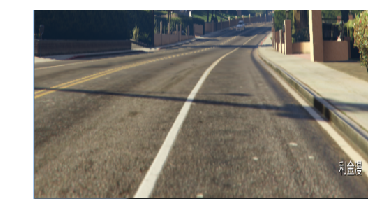

In [8]:
show_saved_data(1)

In [9]:
# 用vertices多边形填充img
def roi(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

In [10]:
# 在img上画粗黑线
def draw_lines(img,lines,color=[255,255,255],width=8):
    for line in lines:
        coords = line[0]
        cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), [255,255,255], 8)

## 探测边界

In [21]:
# 返回高斯滤波后的带有查找的边界标记的原图片
def detect_edge(rgb_image):
    gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)   # 灰度图片
    
    processed_img = cv2.Canny(gray_img, threshold1=48, threshold2=338)   # 阈值查找边缘
    
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )           # 高斯滤波
    
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)   # 霍夫变换查找边界
    
    return processed_img, lines

#### “有窗口”

In [22]:
# 窗口显示img， 标题为pos
def display_image_win(pos,img):
    cv2.imshow(pos, img)

# 按下任意键，关闭窗口
def destroy_win():    
    while True:
        #if cv2.waitKey(25) & 0xFF == ord('q'):
        if cv2.waitKey(0) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

### 尝试探测边界

(<matplotlib.axes._subplots.AxesSubplot at 0x18910e10>,
 Text(0.5,1,'gray'),
 (-0.5, 479.5, 269.5, -0.5))

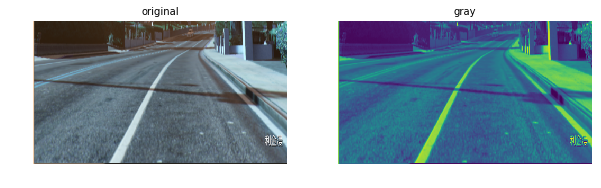

In [23]:
img, action = get_saved_data(1)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(img),plt.title('original', fontsize = 10),plt.axis("off") 
plt.subplot(122), plt.imshow(img_gray),plt.title('gray', fontsize = 10),plt.axis("off") 

### 描边

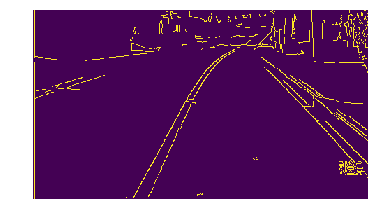

In [30]:
processed_img = cv2.Canny(img, threshold1=200, threshold2=300)
show_raw_img(processed_img)

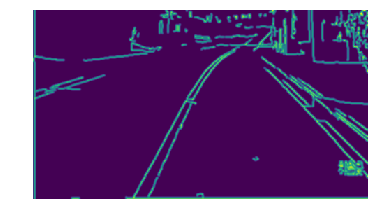

In [31]:
processed_img = cv2.Canny(img, threshold1=200, threshold2=300)
processed_img = cv2.GaussianBlur(processed_img, (5,5), 0)
show_raw_img(processed_img)

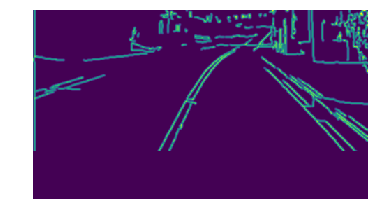

In [32]:
processed_img = cv2.Canny(img, threshold1=200, threshold2=300)
processed_img = cv2.GaussianBlur(processed_img, (5,5), 0)
vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int64)     # 构造多边形
processed_img = roi(processed_img, [vertices])                       # 反差色显示
show_raw_img(processed_img)

In [13]:
# 处理图片，描边滤波、多边形填充
def Gaussi_roi_process(img):
    processed_img = cv2.Canny(img, threshold1=200, threshold2=300)       # 描边标记
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0)            # 3*3，偏差为0的高斯滤波
    vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)     # 构造多边形
    processed_img = roi(processed_img, [vertices])                       # 反差色显示
    # lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)  # 霍夫变换查找边界
    return processed_img

(<matplotlib.axes._subplots.AxesSubplot at 0x18d93978>,
 Text(0.5,1,'img_gray'),
 (-0.5, 479.5, 269.5, -0.5))

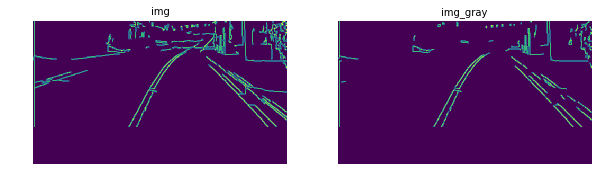

In [14]:
processed_img = Gaussi_roi_process(img)
processed_img_gray = Gaussi_roi_process(img_gray)

plt.figure(figsize=(10,6))
plt.subplot(121), plt.imshow(processed_img),plt.title('img', fontsize = 10),plt.axis("off") 
plt.subplot(122), plt.imshow(processed_img_gray),plt.title('img_gray', fontsize = 10),plt.axis("off") 

(<matplotlib.axes._subplots.AxesSubplot at 0x1a6ede80>,
 Text(0.5,1,'draw_lines'),
 (-0.5, 479.5, 269.5, -0.5))

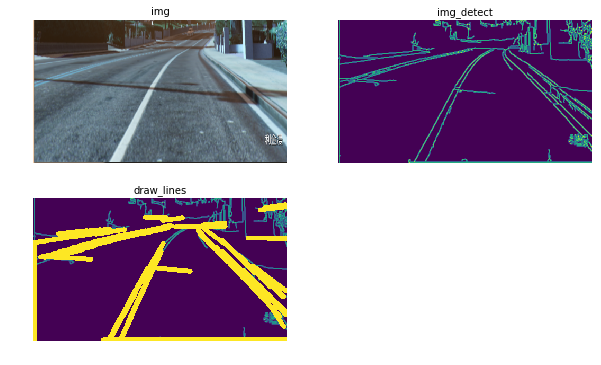

In [34]:
img, action = get_saved_data(1)                     # BGR模式

img_detect, hlines= detect_edge(img)                # 高斯滤波、带有查找到的边界标记

plt.figure(figsize=(10,6))
plt.subplot(221), plt.imshow(img),plt.title('img', fontsize = 10),plt.axis("off")
plt.subplot(222), plt.imshow(img_detect),plt.title('img_detect', fontsize = 10),plt.axis("off") 
draw_lines(img_detect,hlines)                      # 在detect图片上画出标记的边界（方便比较）
plt.subplot(223), plt.imshow(img_detect),plt.title('draw_lines', fontsize = 10),plt.axis("off") 

## 颜色提取color exctraction
- 通过颜色频率分布了解__边界密度__

- 资料参考：
- https://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html
- https://stackoverflow.com/questions/21737613/image-of-hsv-color-wheel-for-opencv

### HSV建模提取颜色区域

In [41]:
# 选取黄色白色区域并返回区域（mask）和位运算的结果
def extract_with_colorBGR(org_img):
    hsv = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)                       # HSV格式

    # 定义黄色和白色阈值
    lower_yellow = np.array([15, 100, 100])
    upper_yellow = np.array([45,255,255])

    lower_white = np.array([0, 0, 0])
    upper_white = np.array([100,0,255])


    # 选取颜色区域，建模
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # 位运算
    res_yellow = cv2.bitwise_and(org_img,org_img, mask= yellow_mask)
    res_white = cv2.bitwise_and(org_img,org_img, mask= white_mask)
    
    return yellow_mask, white_mask, res_yellow, res_white

(<matplotlib.axes._subplots.AxesSubplot at 0x18a1b550>,
 Text(0.5,1,'res_white'),
 (-0.5, 479.5, 269.5, -0.5))

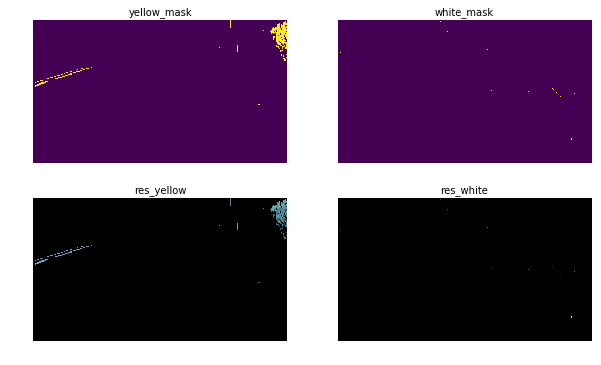

In [42]:
img, action = get_saved_data(1)                                  # BGR格式
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)                       # hsv格式

yellow_mask, white_mask, res_yellow, res_white = extract_with_colorBGR(img)

plt.figure(figsize=(10,6))
plt.subplot(221), plt.imshow(yellow_mask),plt.title('yellow_mask', fontsize = 10),plt.axis("off") 
plt.subplot(222), plt.imshow(white_mask),plt.title('white_mask', fontsize = 10),plt.axis("off") 
plt.subplot(223), plt.imshow(res_yellow),plt.title('res_yellow', fontsize = 10),plt.axis("off") 
plt.subplot(224), plt.imshow(res_white),plt.title('res_white', fontsize = 10),plt.axis("off") 

### HSV边界

In [43]:
# 找出HSV边界，默认黄色
def find_color_lane_BGR(org_img, color='yellow'):
    yellow_mask, white_mask, res_yellow, res_white = extract_with_colorBGR(org_img)
    
    if color=='yellow':
        yellow_edge_img,yellow_edge_lines = detect_edge(res_yellow)
        return yellow_edge_lines
    elif color=='white':
        white_edge_img,white_edge_lines = detect_edge(res_white)
        return white_edge_lines

In [44]:
edge_img,lines = detect_edge(img) # lines: 64条线（1行4列的坐标）
lines.shape

(63, 1, 4)

(<matplotlib.axes._subplots.AxesSubplot at 0x1b55d908>,
 Text(0.5,1,'draw_lines'),
 (-0.5, 479.5, 269.5, -0.5))

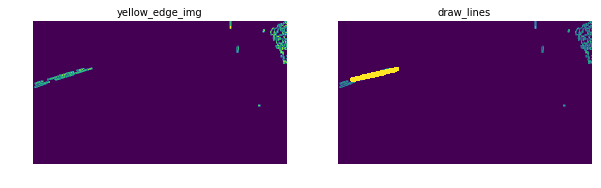

In [45]:
org_img, action = get_saved_data(1)

yellow_mask, white_mask, res_yellow, res_white = extract_with_colorBGR(org_img)

# 先用 color 把黄色的先画出来，然后找边缘
yellow_edge_img, yellow_edge_line = detect_edge(res_yellow)

plt.figure(figsize=(10,6))
plt.subplot(121), plt.imshow(yellow_edge_img),plt.title('yellow_edge_img', fontsize = 10),plt.axis("off") 
draw_lines(yellow_edge_img,yellow_edge_line)
plt.subplot(122), plt.imshow(yellow_edge_img),plt.title('draw_lines', fontsize = 10),plt.axis("off") 

In [46]:
yellow_edge_line, yellow_edge_line.shape

(array([[[ 26, 110, 112,  90]],
 
        [[ 26, 111, 105,  93]]], dtype=int32), (2, 1, 4))

### 颜色聚类
- 颜色分布率    

- https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/

- https://blog.danielparker.com.au/background-colour-detection-using-opencv-and-python-22ed8655b243

In [47]:
from sklearn.cluster import KMeans

In [48]:
# 获取聚类的簇数量，创建并返回直方图
def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)          
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

In [49]:
# 初始化并返回，直方图hist表示相对（总数）频率的条形图
def plot_colors(hist, centroids):
    # 初始化表示每种颜色的相对频率的条形图
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # 遍历每种颜色的百分比以及颜色
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX
        
    return bar

rgb_img (270, 480, 3)
shaped_image (129600, 3)


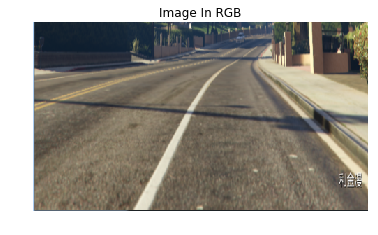

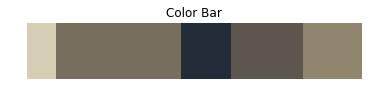

In [50]:
org_img, action = get_saved_data(1)

rgb_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)                         # RGB格式
print('rgb_img',rgb_img.shape)
show_raw_img(rgb_img,'Image In RGB')

shaped_image = rgb_img.reshape((rgb_img.shape[0] * rgb_img.shape[1], 3))  # 重新塑形为单行，方便统计
print('shaped_image',shaped_image.shape)

clt = KMeans(n_clusters = 5)      # k聚类分为5类
clt.fit(shaped_image)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

show_raw_img(bar,'Color Bar')

### Counter.most_common 
- 显示img中出现频率的前几种颜色    
https://github.com/python/cpython/blob/3.6/Lib/heapq.py       

```python
    def most_common(self, n=None):
        '''List the n most common elements and their counts from the most
        common to the least.  If n is None, then list all element counts.
        >>> Counter('abcdeabcdabcaba').most_common(3)
        [('a', 5), ('b', 4), ('c', 3)]
        '''
        # Emulate Bag.sortedByCount from Smalltalk
        if n is None:
            return sorted(self.iteritems(), key=_itemgetter(1), reverse=True)
        return _heapq.nlargest(n, self.iteritems(), key=_itemgetter(1))

```

In [51]:
from collections import Counter

# 统计并返回未排序字典以及颜色频率前6的字典
def count_color(width, height,image):
    manual_count={}
    for y in range(0, width):
        for x in range(0,height):
            rgb = (image[x,y,2],image[x,y,1],image[x,y,0])      # （R,G,B）tuple
            if rgb in manual_count:
                manual_count[rgb][0] += 1
                manual_count[rgb][1].append((x,y))
            else:
                manual_count[rgb] =[1,[(x,y)]]
    number_counter = Counter(manual_count).most_common(6)                
    return manual_count, number_counter

In [52]:
# 显示colors中红色
def draw_colors(colors):
    square_rgb={}
    fig = plt.figure()
    fig.suptitle('RGB Color')
    counter = 231
    for color in colors:        
        square = np.zeros((50, 50, 3), dtype = "uint8")
        square = cv2.rectangle(square, (int(0), 0), (int(50),50),
                               np.array(color[0][::-1],dtype = "uint8").tolist(), -1)  # 显示hongse
        subplot=plt.subplot(counter)  
        subplot.imshow(square)
        subplot.set_title(str(color[0][::-1]))
        subplot.axis("off")        
        counter = counter+1
    plt.show()          

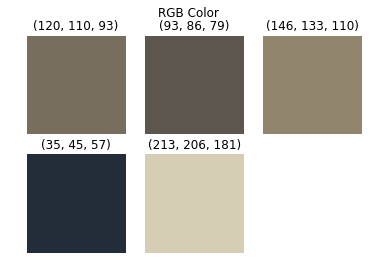

In [53]:
height, width, channels = bar.shape
all_count, top_three = count_color(width, height,bar)
#show_raw_img(bar)
colors = draw_colors(top_three)
#print("image ", height, width,channels)

In [54]:
len(top_three),len(top_three[0]),len(top_three[1]),len(top_three[2]),len(top_three[3]),len(top_three[4])

(5, 2, 2, 2, 2, 2)

###  Canny合适的阈值!!!‘有窗口’
- 实时调整

In [55]:
img_noblur = train_data[1][0]
img = cv2.blur(img_noblur, (7,7))

gray_img = cv2.cvtColor(img_noblur, cv2.COLOR_BGR2GRAY)   
canny_edge = cv2.Canny(gray_img, 0, 0)
cv2.imshow('org', img_noblur) 
cv2.imshow('gray', gray_img) 
cv2.imshow('canny_edge', canny_edge)
cv2.createTrackbar('min_value','canny_edge',0,500, lambda x:None)
cv2.createTrackbar('max_value','canny_edge',0,500, lambda x:None)
 
while(1):
    cv2.imshow('canny_edge', canny_edge)
    p_img = cv2.GaussianBlur(canny_edge, (3,3), 0 )  
    cv2.imshow('after gaussian', p_img)

    min_value = cv2.getTrackbarPos('min_value', 'canny_edge')
    max_value = cv2.getTrackbarPos('max_value', 'canny_edge')
    
    if cv2.waitKey(0) & 0xFF == ord('r'):
        canny_edge = cv2.Canny(gray_img, threshold1=min_value,threshold2=max_value)
        print("set min to ", min_value,  "set max to", max_value)
        
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
    

set min to  0 set max to 0
set min to  195 set max to 193
set min to  0 set max to 0
set min to  139 set max to 0
set min to  139 set max to 299
set min to  139 set max to 500
set min to  0 set max to 500
set min to  0 set max to 500
set min to  37 set max to 500
set min to  37 set max to 500
set min to  6 set max to 500
set min to  6 set max to 500
set min to  0 set max to 500
set min to  303 set max to 500
set min to  203 set max to 500
set min to  103 set max to 500
set min to  88 set max to 500
set min to  88 set max to 500
set min to  94 set max to 500
set min to  94 set max to 500
set min to  94 set max to 500
set min to  94 set max to 500


### 生成带线区域mask

- https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/

In [56]:
# 2行3列的格式显示colors中每一种颜色（6种颜色及其RGB格式）
def draw_colors_rgb(colors):
    square_rgb={}
    fig = plt.figure()
    fig.suptitle('RGB Color')
    counter = 231                                                                # 表示子图集有2行3列
    for color in colors:        
        square = np.zeros((50, 50, 3), dtype = "uint8")
        
        square = cv2.rectangle(square, (int(0), 0), (int(50),50),
                               np.array(color[0],dtype = "uint8").tolist(), -1)
        subplot=plt.subplot(counter)  
        subplot.imshow(square)
        subplot.set_title(str(color[0]))
        subplot.axis("off")        
        counter = counter+1
    plt.show()

In [57]:
# 绘制与img同形状的纯色灰度背景
def draw_mask_image(img):
    nrows, ncolums = img.shape
    canvans = np.zeros((nrows, ncolums, 3), dtype = "uint8")
    canvans = cv2.rectangle(canvans, (int(0), 0), (int(nrows),ncolums),
                               np.array((0,0,0),dtype = "uint8").tolist(), -1)
    return cv2.cvtColor(canvans, cv2.COLOR_BGR2GRAY)

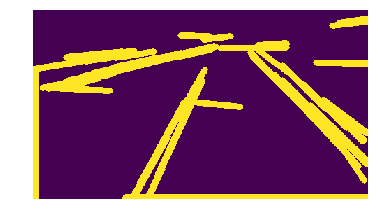

In [58]:
img, action = get_saved_data(1)

img_detect, lines= detect_edge(img)           # 获取标记好的图片以及线列表

mask_img = draw_mask_image(img_detect)       # 绘制与img同形状的纯色灰度背景

draw_lines(mask_img,lines)                   # 在img上划线

show_raw_img(mask_img)

image  270 480 3


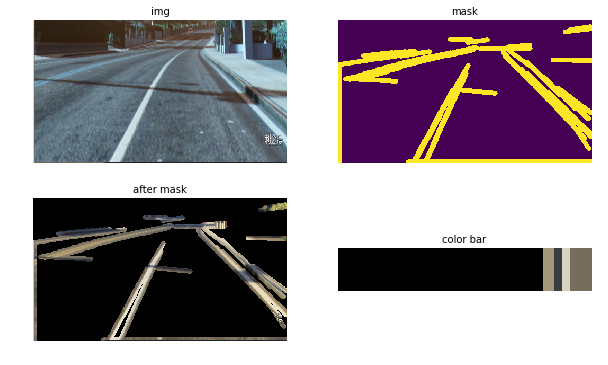

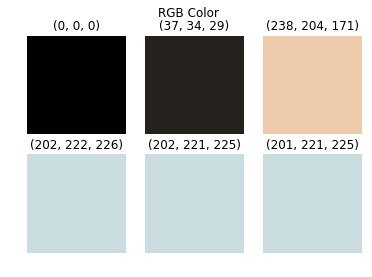

In [59]:
ret, mask = cv2.threshold(mask_img, 10, 255, cv2.THRESH_BINARY)             # 二分阈值得到区域mask

img_fg = cv2.bitwise_and(img,img,mask = mask)                              # 位运算
rgb_img = cv2.cvtColor(img_fg, cv2.COLOR_BGR2RGB)

shaped_image = rgb_img.reshape((rgb_img.shape[0] * rgb_img.shape[1], 3))   # 重塑形

# k-means聚类
clt = KMeans(n_clusters = 5)
clt.fit(shaped_image)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)                             # 聚类得到颜色频率

plt.figure(figsize=(10,6))
plt.subplot(221), plt.imshow(img),plt.title('img', fontsize = 10),plt.axis("off") 
plt.subplot(222), plt.imshow(mask_img),plt.title('mask', fontsize = 10),plt.axis("off") 
plt.subplot(223), plt.imshow(rgb_img),plt.title('after mask', fontsize = 10),plt.axis("off") 
plt.subplot(224), plt.imshow(bar),plt.title('color bar', fontsize = 10),plt.axis("off") 

# 位运算得到的区域频率分析
height, width, channels = rgb_img.shape
print("image ", height, width, channels)
all_count,top_colors = count_color(width, height, img_fg)
colors = draw_colors(top_colors)

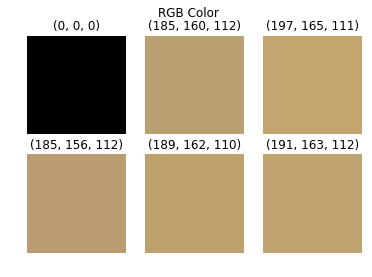

In [60]:
yellow_mask, white_mask, res_yellow, res_white=extract_with_colorBGR(img_fg)

all_count,top_colors = count_color(width, height, res_yellow)
colors = draw_colors_rgb(top_colors)

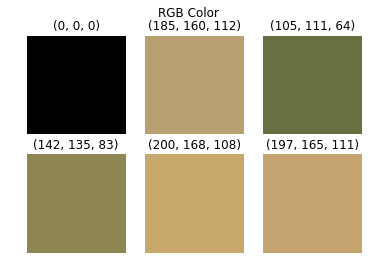

In [61]:
org_img, action = get_saved_data(1)

yellow_mask, white_mask, res_yellow, res_white = extract_with_colorBGR(org_img)

all_count,top_colors = count_color(width, height, res_yellow)
colors = draw_colors_rgb(top_colors)

### test

In [62]:
lines=[[[104, 112, 346, 133]],

       [[129, 269, 479, 269]],

       [[  1, 117,  51, 104]]]
import numpy as np
np.mean(lines,axis=0)

array([[ 78.        , 166.        , 292.        , 168.66666667]])

In [63]:
len(lines), len(lines[0][0])

(3, 4)

In [64]:
lines_zero = [[[]]]
len(lines_zero[0][0])

0

In [65]:
lines=np.array(lines,dtype=np.float)
lines.shape

(3, 1, 4)

In [66]:
np.mean(lines,axis=(0))

array([[ 78.        , 166.        , 292.        , 168.66666667]])

In [67]:
np.mean(yellow_edge_line,axis=0)

array([[ 26. , 110.5, 108.5,  91.5]])

In [68]:
yellow_edge_line

array([[[ 26, 110, 112,  90]],

       [[ 26, 111, 105,  93]]], dtype=int32)

In [69]:
yellow_edge_line

array([[[ 26, 110, 112,  90]],

       [[ 26, 111, 105,  93]]], dtype=int32)

### 操作边界·

These four lines: 用于计算线的定义，给定两组坐标。
        - modified from    
        - http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points

In [70]:
yellow_edge_img,yellow_edge_line = detect_edge(res_yellow)        # 查找res_yellow边界
lines = yellow_edge_line                                          # 原线段矩阵只有两个线段
min_y = 100
max_y = 200

line_dict={}
new_lines = []
print(lines)
print(dict(enumerate(lines)))

[[[ 26 110 112  90]]

 [[ 26 111 105  93]]]
{0: array([[ 26, 110, 112,  90]], dtype=int32), 1: array([[ 26, 111, 105,  93]], dtype=int32)}


In [71]:
# 根据lines中的点，用最小二乘法确定回归方向，使各个线段位于固定Y值范围内
for idx,i in enumerate(lines):                                  # 遍历每一条线的索引以及线
    for xyxy in i:
        x_coords = (xyxy[0],xyxy[2])                            # X坐标
        y_coords = (xyxy[1],xyxy[3])                            # Y坐标
        
        A = vstack([x_coords,ones(len(x_coords))]).T            # 竖向叠加矩阵
        m, b = lstsq(A, y_coords, rcond=None)[0]                # 返回最小二乘法计算的y=mx+b的m，b

        x1 = (min_y-b) / m                                      # Y最小值对应的X
        x2 = (max_y-b) / m                                      # Y最大值对应的X

        line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]] # {索引：m, b, [整合后的线段位置]}
        new_lines.append([int(x1), min_y, int(x2), max_y])
line_dict, new_lines, lines[0], lines[1]

({0: [-0.23255813953488394, 116.04651162790695, [68, 100, -360, 200]],
  1: [-0.22784810126582203, 116.92405063291137, [74, 100, -364, 200]]},
 [[68, 100, -360, 200], [74, 100, -364, 200]],
 array([[ 26, 110, 112,  90]], dtype=int32),
 array([[ 26, 111, 105,  93]], dtype=int32))

In [72]:
# 列表展示新旧lines对比
for line in new_lines:
    print(line, type(line), len(line), end='\t')
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), [255,255,255], 8)

print()
for i in range(len(lines)):
    l = list(lines[i][0])
    print(l, type(l), len(l), end='\t')

[68, 100, -360, 200] <class 'list'> 4	[74, 100, -364, 200] <class 'list'> 4	
[26, 110, 112, 90] <class 'list'> 4	[26, 111, 105, 93] <class 'list'> 4	

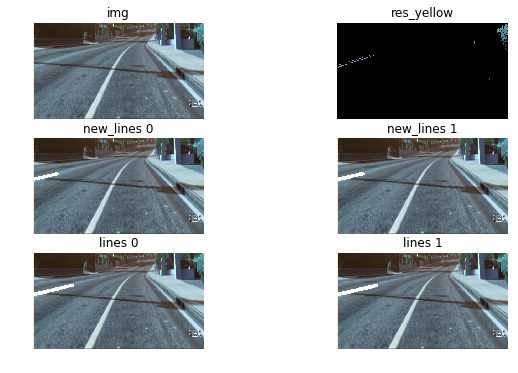

In [73]:
# 画图展示新旧lines对比（新线段保持方向不变合理延长）
img, action = get_saved_data(1)

plt.figure(figsize=(10,6))
plt.subplot(321), plt.imshow(img), plt.title('img'), plt.axis("off")
plt.subplot(322), plt.imshow(res_yellow), plt.title('res_yellow'), plt.axis("off")
i, j = 0, 0
for line in new_lines:
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), [255,255,255], 8)
    plt.subplot(323+i), plt.imshow(img), plt.title('new_lines %d'%i), plt.axis("off")
    i+=1
for i in range(len(lines)):
    l = list(lines[i][0])
    cv2.line(img, (l[0], l[1]), (l[2], l[3]), [255,255,255], 8)
    plt.subplot(325+j), plt.imshow(img), plt.title('lines %d'%i), plt.axis("off")
    j+=1

## 探测道路分割线

### 找出最可能的车道lanes

In [74]:
# 从多个[m,b,lineCoordList]的列表lane_data计算平均坐标
def average_lane(lane_data):
    x1s = []
    y1s = []
    x2s = []
    y2s = []
    for data in lane_data:
        x1s.append(data[2][0])
        y1s.append(data[2][1])
        x2s.append(data[2][2])
        y2s.append(data[2][3])
    return [int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s))]

In [75]:
# 找出标记边界的图片中车道lanes(最长的三条)
def find_main_lanes(img, lines, color=[0, 255, 255], thickness=3):
    """
    使用arc tan找到角度 
    如果我们有好的黄色车道： 
        ＃ 找到1.1角度+ _15的其他车道 
        ＃ 找到做靠近的三车道（如何测量距离？）
    """
    ## 根据lines中的点，用最小二乘法确定回归方向，使各个线段位于固定Y值范围内
    ys = []  
    for i in lines:
        for ii in i:
            ys += [ii[1],ii[3]]
    min_y = min(ys)
    max_y = 270 # HEIGHT
    mid_y = 200
    
    new_lines = []                                                   
    line_dict = {}

    for idx,i in enumerate(lines):
        for xyxy in i:
            x_coords = (xyxy[0],xyxy[2])
            y_coords = (xyxy[1],xyxy[3])
            A = vstack([x_coords,ones(len(x_coords))]).T
            m, b = lstsq(A, y_coords, rcond=None)[0]

            # 计算位移到固定Y值范围内的X值
            x1 = (min_y-b) / m
            x2 = (max_y-b) / m
            
            if x1==float('inf') or x2==float('inf'):
                line_dict[idx] = [m,b,[int(0), min_y, int(0), max_y]]
                new_lines.append([int(0), min_y, int(0), max_y])
            else:
                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])
    
    
    
    ## 查找最终的车道（融合相似的线段，以斜率m为索引存储）
    final_lanes = {}
    found_copy = True
    top_rate = 1.2
    bnt_rate = 2-top_rate

    # 确定图中某条线代表的方向，根据某方向线段数量确定权重
    for idx  in line_dict:
        final_lanes_copy = final_lanes.copy()                    # 保存增加前的final_lanes
        m = line_dict[idx][0]
        b = line_dict[idx][1]
        line = line_dict[idx][2]

        if len(final_lanes) == 0:
            final_lanes[m] = [ [m,b,line] ]                     # 方向（斜率m）作为索引

        else:
            found_copy = False

            for other_ms in final_lanes_copy:
                # 没发现可复制的lanes
                if not found_copy:
                    # 线段相似度处于一定比例
                    if abs(other_ms*top_rate) > abs(m) > abs(other_ms*bnt_rate):     # 当前斜率m与其他斜率差别处于一定比例
                        if abs(final_lanes_copy[other_ms][0][1]*top_rate) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*bnt_rate):  
                        # 当前截距b与其他截距差别处于一定比例
                            final_lanes[other_ms].append([m,b,line])
                            found_copy = True
                            break
                    else:
                        final_lanes[m] = [ [m,b,line] ]
                        
                        
    
    ## 按长度排列（大到小）lanes，并返回
    line_counter = {}                                                            # 统计每个lanes的长度

    for lanes in final_lanes:
        line_counter[lanes] = len(final_lanes[lanes])

    top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1]    # 按字典值（lanes长度）大到小排列的列表
    
    print('78')

#     print('top_lanes', len(top_lanes))
    # lanes长度前三的索引（斜率）
    lane1_id = top_lanes[0][0]
    lane2_id = top_lanes[1][0]
    lane3_id = top_lanes[2][0]
    
#     print(final_lanes[3.432192872032214e-16])
    
    # 长度前三的lanes， 融合成一条线
    l1 = average_lane(final_lanes[lane1_id])
    l2 = average_lane(final_lanes[lane2_id])
    l3 = average_lane(final_lanes[lane3_id])

    return l1,l2,l3

In [76]:
original_image, action = get_saved_data(1)

img, lines = detect_edge(original_image)
print('lines count:', len(lines))

find_main_lanes(original_image,lines,color=1)                # 长度前三的线段集合分别融合为一条线段

lines count: 63
78


([276, 12, 529, 270], [436, 12, -673, 270], [284, 12, 150, 270])

### 展示

In [77]:
# 获得可展示的图片原图和处理图片
def display_lanes(rgb_image):
    original_image = rgb_image   
#     gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    
    # 单色新图片
    processed_img = cv2.Canny(rgb_image, threshold1=200, threshold2=300)       # 阈值为（200，300）的选区区域
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )                 # 高斯滤波 
    
    vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)           # 多边形
    processed_img = roi(processed_img, [vertices])                             # 多边形填充

    
#    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180, 20, 15)
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)          # 霍夫查找？？？
    
    l1,l2,l3 = find_main_lanes(original_image,lines,1)                         # 最可能的三条车道
    
    # 车道生成线段
    cv2.line(original_image, (l1[0], l1[1]), (l1[2], l1[3]), [0,255,0], 10)
    cv2.line(original_image, (l2[0], l2[1]), (l2[2], l2[3]), [0,255,0], 10)
    cv2.line(original_image, (l3[0], l3[1]), (l3[2], l3[3]), [0,255,0], 10)
    
    
    # img图片中划线
    for coords in lines:
        coords = coords[0]
        cv2.line(processed_img, (coords[0], coords[1]), (coords[2], coords[3]), [255,0,0], 3)
    
    return original_image, processed_img

* 左上 x,y=(0,0)
* 左下 (0,270)
* 右上 (480,0)
* 右下 (480,270)

#### 展示画线结果

78


(<matplotlib.axes._subplots.AxesSubplot at 0x1ca2b240>,
 Text(0.5,1,'new_screen'),
 (-0.5, 479.5, 269.5, -0.5))

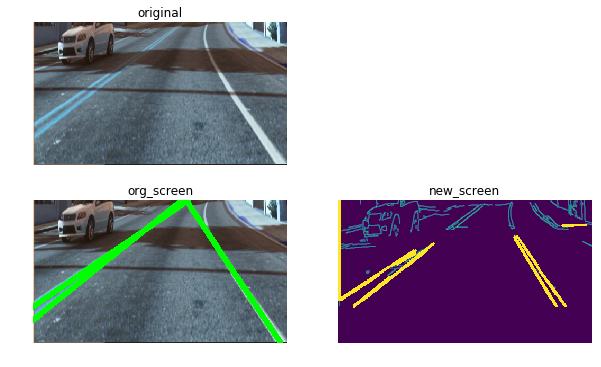

In [78]:
original_image, action = get_saved_data(50)
# gray_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
img_detect, lines = detect_edge(original_image)

plt.figure(figsize=(10,6))
plt.subplot(221), plt.imshow(original_image), plt.title('original'), plt.axis("off")

processed_img = cv2.Canny(img_detect, threshold1=200, threshold2=300)
processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )    
vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
processed_img = roi(processed_img, [vertices])

#    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180, 20, 15)
lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
org_screen, new_screen= display_lanes(original_image)


plt.subplot(223), plt.imshow(org_screen), plt.title('org_screen'), plt.axis("off")
plt.subplot(224), plt.imshow(new_screen), plt.title('new_screen'), plt.axis("off")

In [79]:
for idx in range(len(train_data[idx][0])):
    original_image= train_data[idx][0]

    org_screen, new_screen= display_lanes(original_image)                           # 获得画出车道和画出多线段的图片

78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78
78


D:\setup_space_all\anaconda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
D:\setup_space_all\anaconda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


78
78
78
78
78
78
78
78
78


OverflowError: Python int too large to convert to C long

__END__